# XGBSEKaplanTree

## TAU = quantile(0.90)

In [ ]:
# -----------------------------------
# 0. 경고 무시 및 Optuna 로그 설정
# -----------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import RepeatedKFold
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score,
)
from xgbse import XGBSEKaplanTree

optuna.logging.set_verbosity(optuna.logging.INFO)

# -----------------------------------
# 1. 데이터 로드 및 전처리
# -----------------------------------
# --------------------------
# 1. 데이터 로드 및 변수 선택
# --------------------------
data = pd.read_csv("origin_colon_cancer.csv")
data = data[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000','tx_00000'
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
         'Regional', 'Distant', 'sex',]]
X = data.drop(['stime', 'event_inc'], axis=1)
T = data['stime'].astype(float).values
E = data['event_inc'].astype(bool).values

# 구조화 라벨 (sksurv/xgbse 표준 형식)
y = np.array(list(zip(E, T)), dtype=[('event', bool), ('time', float)])
print("y의 필드 이름:", y.dtype.names)

# -----------------------------------
# 2. 전역 시간 격자 & 고정 지평선 (일관성/누수 방지)
# -----------------------------------
# 너무 비어있는 꼬리를 제외하기 위해 상위 95% 분위수까지만 평가/학습에 사용
T_q95 = np.quantile(y['time'], 0.95)
TIME_BINS_GLOBAL = np.linspace(0.0, T_q95, 50)   # 학습/예측/평가 공통 축 (전 폴드 동일)
TAU = float(np.quantile(y['time'], 0.90))        # C-index 평가 지평선(전 폴드 동일)

# -----------------------------------
# 3. 교차검증 객체
# -----------------------------------
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# -----------------------------------
# 4. Optuna 목적함수 (IBS 최소화)
#    - 전역 공통 격자 사용
#    - 평가 가능한 공통 구간(valid_times)으로 제한
# -----------------------------------
def objective(trial):
    # 하이퍼파라미터 샘플링
    xgb_params = {
        "objective":       "survival:cox",
        "eval_metric":     "cox-nloglik",
        "booster":         "dart",        # 보고/재현성엔 gbtree도 고려 가능
        "tree_method":     "hist",
        "learning_rate":   trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth":       trial.suggest_int("max_depth", 3, 10),
        "subsample":       trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators":    trial.suggest_int("n_estimators", 50, 500),
        "seed":            42,
        # "nthread":       os.cpu_count(),  # xgboost 버전에 따라 nthread/n_jobs 사용
    }

    fold_ibss = []

    for train_idx, test_idx in rkf.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        # 모델 학습 (전역 공통 격자 사용)
        model = XGBSEKaplanTree(xgb_params)
        model.fit(X_tr, y_tr, time_bins=TIME_BINS_GLOBAL)

        # 예측
        surv_df = model.predict(X_te)  # columns == TIME_BINS_GLOBAL
        times = surv_df.columns.astype(float)

        # 평가 가능한 공통 구간으로 제한: 훈련/테스트/예측이 모두 커버하는 상한
        tmax = min(y_tr['time'].max(), y_te['time'].max(), times.max())
        valid_times = times[(times > 0) & (times <= tmax)]
        if valid_times.size < 2:
            # 유효 시점이 너무 적으면 이 trial은 중도 중단
            raise optuna.TrialPruned()

        surv_trim = surv_df.loc[:, valid_times]

        # IBS 계산 (검열 보정 포함)
        ibs = integrated_brier_score(y_tr, y_te, surv_trim, valid_times)
        fold_ibss.append(float(ibs))

    return float(np.mean(fold_ibss))

# -----------------------------------
# 5. Optuna 최적화 실행
# -----------------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("최적 시도:")
print(f"  mean IBS: {study.best_value:.4f}")
print("  params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# 실험 로그 저장(선택)
os.makedirs("BS_results", exist_ok=True)
try:
    trials_df = study.trials_dataframe()
    trials_df.to_csv("BS_results/optuna_trials.csv", index=False)
except Exception as e:
    print("Optuna trials 저장 중 경고:", e)

# -----------------------------------
# 6. 최적 파라미터로 최종 모델 평가 (C-index@TAU / IBS)
# -----------------------------------
best = study.best_params
best_xgb_params = {
    "objective":       "survival:cox",
    "eval_metric":     "cox-nloglik",
    "booster":         "gbtree",     # 필요시 'gbtree'로 바꿔 재현성↑ 테스트 권장
    "tree_method":     "hist",
    "learning_rate":   best["learning_rate"],
    "max_depth":       best["max_depth"],
    "subsample":       best["subsample"],
    "colsample_bytree":best["colsample_bytree"],
    "n_estimators":    best["n_estimators"],
    "seed":            42,
}

cindex_scores = []
ibs_scores    = []
fold_times    = []
fold_brier    = []

for fold, (train_idx, test_idx) in enumerate(rkf.split(X), 1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # 학습 & 예측 (전역 공통 격자 사용)
    model = XGBSEKaplanTree(best_xgb_params)
    model.fit(X_tr, y_tr, time_bins=TIME_BINS_GLOBAL)
    surv_df = model.predict(X_te)

    times = surv_df.columns.astype(float)
    tmax  = min(y_tr['time'].max(), y_te['time'].max(), times.max())
    valid_times = times[(times > 0) & (times <= tmax)]
    if valid_times.size < 2:
        # 드물지만 방어적으로 스킵하거나 0으로 채우는 선택 가능
        continue

    surv_trim = surv_df.loc[:, valid_times]

    # C-index @ 고정 지평선 TAU: risk = 1 - S(TAU)
    idx_tau = int(np.argmin(np.abs(valid_times - TAU)))
    risk_scores = 1.0 - surv_trim.iloc[:, idx_tau].values
    cidx = float(concordance_index_ipcw(y_tr, y_te, risk_scores, tau=TAU)[0])

    # IBS & per-time Brier
    ibs  = float(integrated_brier_score(y_tr, y_te, surv_trim, valid_times))
    t_grid, b = brier_score(y_tr, y_te, surv_trim, valid_times)

    cindex_scores.append(cidx)
    ibs_scores.append(ibs)
    fold_times.append(t_grid)
    fold_brier.append(b)

    print(f"폴드 {fold:02d} — C-index@{TAU:.1f}m: {cidx:.3f}, IBS: {ibs:.3f}")

# 요약 출력
if len(cindex_scores) > 0:
    print(f"\n평균 C-index@{TAU:.1f}m: {np.mean(cindex_scores):.3f} ± {np.std(cindex_scores):.3f}")
    print(f"평균 IBS:             {np.mean(ibs_scores):.3f} ± {np.std(ibs_scores):.3f}")
else:
    print("\n유효 폴드가 없어 요약 통계를 계산하지 못했습니다.")

# 요약 저장(선택)
try:
    summary = pd.DataFrame({
        "fold": np.arange(1, len(cindex_scores)+1),
        "cindex_at_tau": cindex_scores,
        "ibs": ibs_scores
    })
    summary.to_csv("BS_results/cv_summary.csv", index=False)
except Exception as e:
    print("CV 요약 저장 경고:", e)

# -----------------------------------
# 7. 최적 폴드 저장 및 시각화
# -----------------------------------
if len(ibs_scores) > 0:
    best_idx   = int(np.argmin(ibs_scores))
    best_time  = fold_times[best_idx]
    best_brier = fold_brier[best_idx]

    np.save("BS_results/kaplantree_best_time.npy", best_time)
    np.save("BS_results/kaplantree_best_brier.npy", best_brier)

    plt.figure(figsize=(10, 6))
    for i, (t, b) in enumerate(zip(fold_times, fold_brier), 1):
        plt.plot(t, b, label=f'Fold {i}', alpha=0.7)
    plt.xlabel('Time (months)')
    plt.ylabel('Brier score')
    plt.title(f'Time-dependent Brier score (XGBSEKaplanTree, τ={TAU:.1f}m)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("BS_results/brier_score_plot.png")
    plt.close()

[I 2025-08-20 22:46:50,549] A new study created in memory with name: no-name-e2295d4e-36ff-492d-9abe-27d5616e23d6


y의 필드 이름: ('event', 'time')


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-20 22:46:53,581] Trial 0 finished with value: 0.1488189977322249 and parameters: {'learning_rate': 0.025643393879887056, 'max_depth': 6, 'subsample': 0.9208862936493996, 'colsample_bytree': 0.6313238503255473, 'n_estimators': 205}. Best is trial 0 with value: 0.1488189977322249.
[I 2025-08-20 22:46:58,790] Trial 1 finished with value: 0.1492896119914354 and parameters: {'learning_rate': 0.22302811901651853, 'max_depth': 9, 'subsample': 0.7624622186640405, 'colsample_bytree': 0.964623733542248, 'n_estimators': 473}. Best is trial 0 with value: 0.1488189977322249.
[I 2025-08-20 22:47:02,220] Trial 2 finished with value: 0.1487582128534482 and parameters: {'learning_rate': 0.07782656767262759, 'max_depth': 7, 'subsample': 0.9234250366188025, 'colsample_bytree': 0.7040163876250514, 'n_estimators': 332}. Best is trial 2 with value: 0.1487582128534482.
[I 2025-08-20 22:47:06,577] Trial 3 finished with value: 0.15530911943824388 and parameters: {'learning_rate': 0.02614185000578283

## TAU = 0.80

In [ ]:
# -----------------------------------
# 0. 경고 무시 및 Optuna 로그 설정
# -----------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import RepeatedKFold
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score,
)
from xgbse import XGBSEKaplanTree

optuna.logging.set_verbosity(optuna.logging.INFO)

# -----------------------------------
# 1. 데이터 로드 및 전처리
# -----------------------------------
data = pd.read_csv("origin_colon_cancer.csv")
data = data[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000','tx_00000'
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
         'Regional', 'Distant', 'sex',]]

X = data.drop(['stime', 'event_inc'], axis=1)
T = data['stime'].astype(float).values
E = data['event_inc'].astype(bool).values

# 구조화 라벨 (sksurv/xgbse 표준 형식)
y = np.array(list(zip(E, T)), dtype=[('event', bool), ('time', float)])
print("y의 필드 이름:", y.dtype.names)

# -----------------------------------
# 2. 전역 시간 격자 & 고정 지평선 (일관성/누수 방지)
# -----------------------------------
# 너무 비어있는 꼬리를 제외하기 위해 상위 95% 분위수까지만 평가/학습에 사용
T_q95 = np.quantile(y['time'], 0.95)
TIME_BINS_GLOBAL = np.linspace(0.0, T_q95, 50)   # 학습/예측/평가 공통 축 (전 폴드 동일)
TAU = float(np.quantile(y['time'], 0.80))        # C-index 평가 지평선(전 폴드 동일)

# -----------------------------------
# 3. 교차검증 객체
# -----------------------------------
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# -----------------------------------
# 4. Optuna 목적함수 (IBS 최소화)
#    - 전역 공통 격자 사용
#    - 평가 가능한 공통 구간(valid_times)으로 제한
# -----------------------------------
def objective(trial):
    # 하이퍼파라미터 샘플링
    xgb_params = {
        "objective":       "survival:cox",
        "eval_metric":     "cox-nloglik",
        "booster":         "dart",        # 보고/재현성엔 gbtree도 고려 가능
        "tree_method":     "hist",
        "learning_rate":   trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth":       trial.suggest_int("max_depth", 3, 10),
        "subsample":       trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators":    trial.suggest_int("n_estimators", 50, 500),
        "seed":            42,
        # "nthread":       os.cpu_count(),  # xgboost 버전에 따라 nthread/n_jobs 사용
    }

    fold_ibss = []

    for train_idx, test_idx in rkf.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        # 모델 학습 (전역 공통 격자 사용)
        model = XGBSEKaplanTree(xgb_params)
        model.fit(X_tr, y_tr, time_bins=TIME_BINS_GLOBAL)

        # 예측
        surv_df = model.predict(X_te)  # columns == TIME_BINS_GLOBAL
        times = surv_df.columns.astype(float)

        # 평가 가능한 공통 구간으로 제한: 훈련/테스트/예측이 모두 커버하는 상한
        tmax = min(y_tr['time'].max(), y_te['time'].max(), times.max())
        valid_times = times[(times > 0) & (times <= tmax)]
        if valid_times.size < 2:
            # 유효 시점이 너무 적으면 이 trial은 중도 중단
            raise optuna.TrialPruned()

        surv_trim = surv_df.loc[:, valid_times]

        # IBS 계산 (검열 보정 포함)
        ibs = integrated_brier_score(y_tr, y_te, surv_trim, valid_times)
        fold_ibss.append(float(ibs))

    return float(np.mean(fold_ibss))

# -----------------------------------
# 5. Optuna 최적화 실행
# -----------------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("최적 시도:")
print(f"  mean IBS: {study.best_value:.4f}")
print("  params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# 실험 로그 저장(선택)
os.makedirs("BS_results", exist_ok=True)
try:
    trials_df = study.trials_dataframe()
    trials_df.to_csv("BS_results/optuna_trials.csv", index=False)
except Exception as e:
    print("Optuna trials 저장 중 경고:", e)

# -----------------------------------
# 6. 최적 파라미터로 최종 모델 평가 (C-index@TAU / IBS)
# -----------------------------------
best = study.best_params
best_xgb_params = {
    "objective":       "survival:cox",
    "eval_metric":     "cox-nloglik",
    "booster":         "gbtree",     # 필요시 'gbtree'로 바꿔 재현성↑ 테스트 권장
    "tree_method":     "hist",
    "learning_rate":   best["learning_rate"],
    "max_depth":       best["max_depth"],
    "subsample":       best["subsample"],
    "colsample_bytree":best["colsample_bytree"],
    "n_estimators":    best["n_estimators"],
    "seed":            42,
}

cindex_scores = []
ibs_scores    = []
fold_times    = []
fold_brier    = []

for fold, (train_idx, test_idx) in enumerate(rkf.split(X), 1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # 학습 & 예측 (전역 공통 격자 사용)
    model = XGBSEKaplanTree(best_xgb_params)
    model.fit(X_tr, y_tr, time_bins=TIME_BINS_GLOBAL)
    surv_df = model.predict(X_te)

    times = surv_df.columns.astype(float)
    tmax  = min(y_tr['time'].max(), y_te['time'].max(), times.max())
    valid_times = times[(times > 0) & (times <= tmax)]
    if valid_times.size < 2:
        # 드물지만 방어적으로 스킵하거나 0으로 채우는 선택 가능
        continue

    surv_trim = surv_df.loc[:, valid_times]

    # C-index @ 고정 지평선 TAU: risk = 1 - S(TAU)
    idx_tau = int(np.argmin(np.abs(valid_times - TAU)))
    risk_scores = 1.0 - surv_trim.iloc[:, idx_tau].values
    cidx = float(concordance_index_ipcw(y_tr, y_te, risk_scores, tau=TAU)[0])

    # IBS & per-time Brier
    ibs  = float(integrated_brier_score(y_tr, y_te, surv_trim, valid_times))
    t_grid, b = brier_score(y_tr, y_te, surv_trim, valid_times)

    cindex_scores.append(cidx)
    ibs_scores.append(ibs)
    fold_times.append(t_grid)
    fold_brier.append(b)

    print(f"폴드 {fold:02d} — C-index@{TAU:.1f}m: {cidx:.3f}, IBS: {ibs:.3f}")

# 요약 출력
if len(cindex_scores) > 0:
    print(f"\n평균 C-index@{TAU:.1f}m: {np.mean(cindex_scores):.3f} ± {np.std(cindex_scores):.3f}")
    print(f"평균 IBS:             {np.mean(ibs_scores):.3f} ± {np.std(ibs_scores):.3f}")
else:
    print("\n유효 폴드가 없어 요약 통계를 계산하지 못했습니다.")

# 요약 저장(선택)
try:
    summary = pd.DataFrame({
        "fold": np.arange(1, len(cindex_scores)+1),
        "cindex_at_tau": cindex_scores,
        "ibs": ibs_scores
    })
    summary.to_csv("BS_results/cv_summary.csv", index=False)
except Exception as e:
    print("CV 요약 저장 경고:", e)

# -----------------------------------
# 7. 최적 폴드 저장 및 시각화
# -----------------------------------
if len(ibs_scores) > 0:
    best_idx   = int(np.argmin(ibs_scores))
    best_time  = fold_times[best_idx]
    best_brier = fold_brier[best_idx]

    np.save("BS_results/kaplantree_best_time.npy", best_time)
    np.save("BS_results/kaplantree_best_brier.npy", best_brier)

    plt.figure(figsize=(10, 6))
    for i, (t, b) in enumerate(zip(fold_times, fold_brier), 1):
        plt.plot(t, b, label=f'Fold {i}', alpha=0.7)
    plt.xlabel('Time (months)')
    plt.ylabel('Brier score')
    plt.title(f'Time-dependent Brier score (XGBSEKaplanTree, τ={TAU:.1f}m)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("BS_results/brier_score_plot.png")
    plt.close()

[I 2025-08-21 04:37:23,429] A new study created in memory with name: no-name-212e2fce-a73c-47f7-ad2f-da854a959b7f


y의 필드 이름: ('event', 'time')


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-21 04:37:26,479] Trial 0 finished with value: 0.1519287628407905 and parameters: {'learning_rate': 0.027320045264584675, 'max_depth': 4, 'subsample': 0.6002142829856725, 'colsample_bytree': 0.8081071042021504, 'n_estimators': 437}. Best is trial 0 with value: 0.1519287628407905.
[I 2025-08-21 04:37:30,989] Trial 1 finished with value: 0.14881910468075107 and parameters: {'learning_rate': 0.12522655327921225, 'max_depth': 8, 'subsample': 0.9384611684505508, 'colsample_bytree': 0.6592617790255965, 'n_estimators': 474}. Best is trial 1 with value: 0.14881910468075107.
[I 2025-08-21 04:37:35,531] Trial 2 finished with value: 0.15537031518967134 and parameters: {'learning_rate': 0.01513388864003182, 'max_depth': 3, 'subsample': 0.8680296663265076, 'colsample_bytree': 0.8388524027352562, 'n_estimators': 228}. Best is trial 1 with value: 0.14881910468075107.
[I 2025-08-21 04:37:38,554] Trial 3 finished with value: 0.15179376233366626 and parameters: {'learning_rate': 0.054654833381

# XGBSEDebiasedBCE

## TAU = 0.90

In [ ]:
# -----------------------------------
# 0. 경고 무시 및 Optuna 로그 설정
# -----------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import RepeatedKFold
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score,
)
from xgbse import XGBSEDebiasedBCE
from xgbse.converters import convert_to_structured

optuna.logging.set_verbosity(optuna.logging.INFO)

# -----------------------------------
# 1. 데이터 로드 및 전처리
# -----------------------------------
data = pd.read_csv("origin_colon_cancer.csv")
data = data[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000','tx_00000'
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
         'Regional', 'Distant', 'sex',]]

X = data.drop(['stime', 'event_inc'], axis=1)
T = data['stime'].astype(float).values
E = data['event_inc'].astype(bool).values
y = np.array(list(zip(E, T)), dtype=[('event', bool), ('time', float)])# dtype [('event', bool), ('time', float)]

# -----------------------------------
# 2. 전역 시간 격자 & 고정 지평선 (일관성/누수 방지)
# -----------------------------------
T_q95 = np.quantile(y['time'], 0.95)
TIME_BINS_GLOBAL = np.linspace(0.0, T_q95, 50)   # 학습/예측/평가 공통 축
TAU = float(np.quantile(y['time'], 0.90))        # C-index 고정 지평선

# -----------------------------------
# 3. 교차검증 객체
# -----------------------------------
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# -----------------------------------
# 4. Optuna 목적함수 (IBS 최소화)
#    * 차이점: DebiasedBCE는 xgb_params + lr_params(C) 튜닝
# -----------------------------------
def objective(trial):
    xgb_params = {
        "objective":   "survival:cox",
        "eval_metric": "cox-nloglik",
        "booster":     "gbtree",                 # dart 대신 gbtree로 시작 (안정성)
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth":     trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0),
        "subsample":       trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree":trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators":    trial.suggest_int("n_estimators", 20, 200),
        "random_state":    42,
        "n_jobs":          os.cpu_count(),
    }
    lr_params = {
        "C": trial.suggest_float("lr_C", 0.05, 10.0, log=True)   # 로지스틱 회귀 정규화 강도
    }

    fold_ibss = []
    for train_idx, test_idx in rkf.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        model = XGBSEDebiasedBCE(xgb_params=xgb_params, lr_params=lr_params, n_jobs=os.cpu_count())
        model.fit(X_tr, y_tr, time_bins=TIME_BINS_GLOBAL)   # 전역 고정 격자 사용
        surv_df = model.predict(X_te)                       # columns == TIME_BINS_GLOBAL
        times = surv_df.columns.astype(float)

        # 평가 가능한 공통 구간으로 제한
        tmax = min(y_tr['time'].max(), y_te['time'].max(), times.max())
        valid_times = times[(times > 0) & (times <= tmax)]
        if valid_times.size < 2:
            raise optuna.TrialPruned()

        surv_trim = surv_df.loc[:, valid_times]
        ibs = float(integrated_brier_score(y_tr, y_te, surv_trim, valid_times))
        fold_ibss.append(ibs)

    return float(np.mean(fold_ibss))

# -----------------------------------
# 5. Optuna 실행
# -----------------------------------
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
)
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

print("최적 시도:")
print(f"  mean IBS: {study.best_value:.4f}")
print("  params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# -----------------------------------
# 6. 최적 파라미터로 최종 CV 평가 (C-index/IBS)
# -----------------------------------
best = study.best_params
best_xgb_params = {
    "objective":   "survival:cox",
    "eval_metric": "cox-nloglik",
    "booster":     "gbtree",
    "tree_method": "hist",
    "learning_rate": best["learning_rate"],
    "max_depth":     best["max_depth"],
    "min_child_weight": best["min_child_weight"],
    "subsample":     best["subsample"],
    "colsample_bytree": best["colsample_bytree"],
    "n_estimators":  best["n_estimators"],
    "random_state": 42,
    "n_jobs":       os.cpu_count(),
}
best_lr_params = {"C": best["lr_C"]}

cindex_scores = []
ibs_scores    = []
fold_times    = []
fold_brier    = []

for fold, (train_idx, test_idx) in enumerate(rkf.split(X), 1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    model = XGBSEDebiasedBCE(xgb_params=best_xgb_params, lr_params=best_lr_params, n_jobs=os.cpu_count())
    model.fit(X_tr, y_tr, time_bins=TIME_BINS_GLOBAL)
    surv_df = model.predict(X_te)
    times = surv_df.columns.astype(float)

    # 평가 가능한 공통 구간
    tmax = min(y_tr['time'].max(), y_te['time'].max(), times.max())
    valid_times = times[(times > 0) & (times <= tmax)]
    surv_trim = surv_df.loc[:, valid_times]

    # C-index at fixed TAU: risk = 1 - S(TAU)
    idx_tau = int(np.argmin(np.abs(valid_times - TAU)))
    risk_scores = 1.0 - surv_trim.iloc[:, idx_tau].values
    cidx = float(concordance_index_ipcw(y_tr, y_te, risk_scores, tau=TAU)[0])

    # IBS & per-time Brier
    ibs  = float(integrated_brier_score(y_tr, y_te, surv_trim, valid_times))
    t_grid, b = brier_score(y_tr, y_te, surv_trim, valid_times)

    cindex_scores.append(cidx)
    ibs_scores.append(ibs)
    fold_times.append(t_grid)
    fold_brier.append(b)

    print(f"폴드 {fold:02d} — C-index: {cidx:.3f}, IBS: {ibs:.3f}")

print(f"\n평균 C-index: {np.mean(cindex_scores):.3f} ± {np.std(cindex_scores):.3f}")
print(f"평균 IBS:     {np.mean(ibs_scores):.3f} ± {np.std(ibs_scores):.3f}")

# -----------------------------------
# 7. 결과 저장/시각화
# -----------------------------------
os.makedirs("BS_results", exist_ok=True)
best_idx   = int(np.argmin(ibs_scores))
best_time  = fold_times[best_idx]
best_brier = fold_brier[best_idx]
np.save("BS_results/debiasedbce_best_time.npy", best_time)
np.save("BS_results/debiasedbce_best_brier.npy", best_brier)

plt.figure(figsize=(10, 6))
for i, (t, b) in enumerate(zip(fold_times, fold_brier), 1):
    plt.plot(t, b, label=f'Fold {i}', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Brier score')
plt.title('Time-dependent Brier score (XGBSEDebiasedBCE, best params)')
plt.legend()
plt.tight_layout()
plt.savefig("BS_results/brier_score_plot.png")
plt.close()

[I 2025-08-21 04:42:18,217] A new study created in memory with name: no-name-7750cae5-d1c0-47c8-a2c1-971886889d0a


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:42:27,943] Trial 0 finished with value: 0.15110633211969074 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 6, 'min_child_weight': 14.907884894416696, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.6624074561769746, 'n_estimators': 48, 'lr_C': 0.0680177306805904}. Best is trial 0 with value: 0.15110633211969074.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:42:35,438] Trial 1 finished with value: 0.14700603333756337 and parameters: {'learning_rate': 0.13394334706750485, 'max_depth': 5, 'min_child_weight': 14.453378978124864, 'subsample': 0.7061753482887407, 'colsample_bytree': 0.9879639408647978, 'n_estimators': 170, 'lr_C': 0.15401700264919846}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:42:42,243] Trial 2 finished with value: 0.15311981429701116 and parameters: {'learning_rate': 0.017240892195821537, 'max_depth': 2, 'min_child_weight': 6.780602616231217, 'subsample': 0.8574269294896714, 'colsample_bytree': 0.7727780074568463, 'n_estimators': 72, 'lr_C': 1.2789744480473686}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:42:49,275] Trial 3 finished with value: 0.14945769394957045 and parameters: {'learning_rate': 0.01518747922672247, 'max_depth': 3, 'min_child_weight': 7.960875022580142, 'subsample': 0.8368209952651108, 'colsample_bytree': 0.9140703845572055, 'n_estimators': 56, 'lr_C': 0.7624982862606782}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:42:56,072] Trial 4 finished with value: 0.15052405761795262 and parameters: {'learning_rate': 0.05898602410432694, 'max_depth': 2, 'min_child_weight': 12.54335218612733, 'subsample': 0.7511572371061874, 'colsample_bytree': 0.6260206371941118, 'n_estimators': 191, 'lr_C': 8.335243225327348}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:43:03,066] Trial 5 finished with value: 0.14830391816826322 and parameters: {'learning_rate': 0.11265466963346032, 'max_depth': 3, 'min_child_weight': 2.8557701661212933, 'subsample': 0.905269907953647, 'colsample_bytree': 0.7760609974958406, 'n_estimators': 42, 'lr_C': 0.6892661133923992}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:43:10,508] Trial 6 finished with value: 0.14667692088124842 and parameters: {'learning_rate': 0.011085122517311707, 'max_depth': 6, 'min_child_weight': 5.916819650400321, 'subsample': 0.8987566853061946, 'colsample_bytree': 0.7246844304357644, 'n_estimators': 114, 'lr_C': 0.9056632724016693}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:43:18,136] Trial 7 finished with value: 0.1467842698618309 and parameters: {'learning_rate': 0.017398074711291726, 'max_depth': 6, 'min_child_weight': 15.727523643861176, 'subsample': 0.9818496824692567, 'colsample_bytree': 0.9579309401710595, 'n_estimators': 128, 'lr_C': 6.610438533702809}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:43:24,757] Trial 8 finished with value: 0.15393252059287055 and parameters: {'learning_rate': 0.01303561122512888, 'max_depth': 2, 'min_child_weight': 1.8593184893002233, 'subsample': 0.7975990992289793, 'colsample_bytree': 0.7554709158757928, 'n_estimators': 69, 'lr_C': 4.035709261084851}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:43:31,742] Trial 9 finished with value: 0.1489299671137753 and parameters: {'learning_rate': 0.02911701023242742, 'max_depth': 3, 'min_child_weight': 11.31122558000672, 'subsample': 0.7422772674924287, 'colsample_bytree': 0.9208787923016158, 'n_estimators': 33, 'lr_C': 9.328814293896228}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:43:38,955] Trial 10 finished with value: 0.14698965028078778 and parameters: {'learning_rate': 0.046589863196059025, 'max_depth': 5, 'min_child_weight': 19.421205104969456, 'subsample': 0.9611480919324079, 'colsample_bytree': 0.7090747508804338, 'n_estimators': 117, 'lr_C': 0.33912495250175956}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:43:46,758] Trial 11 finished with value: 0.14689711525953184 and parameters: {'learning_rate': 0.010193060666576633, 'max_depth': 6, 'min_child_weight': 19.24728348205656, 'subsample': 0.9984124347655644, 'colsample_bytree': 0.8499060943322396, 'n_estimators': 126, 'lr_C': 2.285869367464647}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:43:54,386] Trial 12 finished with value: 0.14689710775603126 and parameters: {'learning_rate': 0.021939308288506768, 'max_depth': 5, 'min_child_weight': 6.306588949652774, 'subsample': 0.9370008331185945, 'colsample_bytree': 0.8366173410385278, 'n_estimators': 143, 'lr_C': 3.0186618527139344}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:44:02,024] Trial 13 finished with value: 0.1472625243725477 and parameters: {'learning_rate': 0.010431891094960023, 'max_depth': 6, 'min_child_weight': 16.000064260069834, 'subsample': 0.996698982505996, 'colsample_bytree': 0.9961131887154773, 'n_estimators': 94, 'lr_C': 0.2738318935497195}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:44:09,345] Trial 14 finished with value: 0.14747914505402657 and parameters: {'learning_rate': 0.02197901162815373, 'max_depth': 4, 'min_child_weight': 9.324473182331554, 'subsample': 0.9346779529742273, 'colsample_bytree': 0.7047668630524025, 'n_estimators': 151, 'lr_C': 1.6123800541786035}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:44:17,143] Trial 15 finished with value: 0.1468536942336243 and parameters: {'learning_rate': 0.0779582456544038, 'max_depth': 5, 'min_child_weight': 4.404703261541398, 'subsample': 0.8962678423796924, 'colsample_bytree': 0.8952393368504931, 'n_estimators': 94, 'lr_C': 5.25328796293036}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:44:24,582] Trial 16 finished with value: 0.15111288043826643 and parameters: {'learning_rate': 0.03241694341516341, 'max_depth': 6, 'min_child_weight': 16.588972810547148, 'subsample': 0.9584651107405324, 'colsample_bytree': 0.8269787754697795, 'n_estimators': 97, 'lr_C': 0.0529976311697397}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:44:31,923] Trial 17 finished with value: 0.14752975520211425 and parameters: {'learning_rate': 0.020739880825500198, 'max_depth': 4, 'min_child_weight': 12.645254096650445, 'subsample': 0.9172271903968322, 'colsample_bytree': 0.7164286284415825, 'n_estimators': 136, 'lr_C': 0.6500856946586717}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:44:39,540] Trial 18 finished with value: 0.1467418300568067 and parameters: {'learning_rate': 0.012696102743130272, 'max_depth': 6, 'min_child_weight': 4.237007355769932, 'subsample': 0.8296365868523121, 'colsample_bytree': 0.6043752637736761, 'n_estimators': 169, 'lr_C': 1.3364454689854197}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:44:47,029] Trial 19 finished with value: 0.14688752890999873 and parameters: {'learning_rate': 0.01340679916989291, 'max_depth': 5, 'min_child_weight': 4.445094497342195, 'subsample': 0.8216617011670944, 'colsample_bytree': 0.6028102832946957, 'n_estimators': 200, 'lr_C': 1.1918064126059458}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:44:54,282] Trial 20 finished with value: 0.1466305629018672 and parameters: {'learning_rate': 0.18641791319739015, 'max_depth': 4, 'min_child_weight': 4.410932428528828, 'subsample': 0.7929220735682265, 'colsample_bytree': 0.6733221423256304, 'n_estimators': 166, 'lr_C': 0.28774266409778954}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:01,565] Trial 21 finished with value: 0.14686588109123974 and parameters: {'learning_rate': 0.17604308500452873, 'max_depth': 4, 'min_child_weight': 4.265799065295743, 'subsample': 0.8056171793290423, 'colsample_bytree': 0.6617418661748834, 'n_estimators': 166, 'lr_C': 0.31178070622315096}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:08,904] Trial 22 finished with value: 0.14682219337027558 and parameters: {'learning_rate': 0.07579479076823928, 'max_depth': 4, 'min_child_weight': 1.220149418608254, 'subsample': 0.7644658748216038, 'colsample_bytree': 0.6483772040671096, 'n_estimators': 177, 'lr_C': 0.4253284561654922}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:16,196] Trial 23 finished with value: 0.14722849453260262 and parameters: {'learning_rate': 0.1825658967933412, 'max_depth': 5, 'min_child_weight': 5.996086147738337, 'subsample': 0.8621060235196516, 'colsample_bytree': 0.6794118334815079, 'n_estimators': 152, 'lr_C': 0.15797332500975342}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:23,576] Trial 24 finished with value: 0.14742240391168068 and parameters: {'learning_rate': 0.044681539413815294, 'max_depth': 6, 'min_child_weight': 8.255507504170605, 'subsample': 0.7778942019243313, 'colsample_bytree': 0.7438070566926878, 'n_estimators': 183, 'lr_C': 0.19423692903144238}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:30,470] Trial 25 finished with value: 0.14784024002266022 and parameters: {'learning_rate': 0.08897109696101539, 'max_depth': 3, 'min_child_weight': 2.9996085970462296, 'subsample': 0.8340321188249346, 'colsample_bytree': 0.6057165634550705, 'n_estimators': 161, 'lr_C': 0.8835346184329348}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:37,753] Trial 26 finished with value: 0.14710916040636277 and parameters: {'learning_rate': 0.011806671424506523, 'max_depth': 5, 'min_child_weight': 5.334302271014237, 'subsample': 0.8784828527469319, 'colsample_bytree': 0.6282572457368232, 'n_estimators': 110, 'lr_C': 0.5054722850325963}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:44,835] Trial 27 finished with value: 0.14732290322786878 and parameters: {'learning_rate': 0.03885905732136871, 'max_depth': 4, 'min_child_weight': 7.803789571138093, 'subsample': 0.7954751800995254, 'colsample_bytree': 0.6881617703770504, 'n_estimators': 22, 'lr_C': 2.1122345680294035}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:52,278] Trial 28 finished with value: 0.14637845486540738 and parameters: {'learning_rate': 0.127187192404266, 'max_depth': 6, 'min_child_weight': 10.063970123917958, 'subsample': 0.8183349292716899, 'colsample_bytree': 0.7307975049873044, 'n_estimators': 154, 'lr_C': 1.191301405540712}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:45:59,624] Trial 29 finished with value: 0.14891027496011247 and parameters: {'learning_rate': 0.13146341348350835, 'max_depth': 6, 'min_child_weight': 10.182000493893646, 'subsample': 0.726420895507981, 'colsample_bytree': 0.73436156399929, 'n_estimators': 107, 'lr_C': 0.09287952832607765}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:46:06,620] Trial 30 finished with value: 0.14784995808242218 and parameters: {'learning_rate': 0.19760622099381644, 'max_depth': 5, 'min_child_weight': 9.5668192138974, 'subsample': 0.8831360637386765, 'colsample_bytree': 0.7864596601625291, 'n_estimators': 155, 'lr_C': 0.10167028017512315}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:46:14,002] Trial 31 finished with value: 0.1465329232065483 and parameters: {'learning_rate': 0.14852974052147927, 'max_depth': 6, 'min_child_weight': 3.1174157582750803, 'subsample': 0.8243521656632578, 'colsample_bytree': 0.6473712835478873, 'n_estimators': 141, 'lr_C': 1.099949973984762}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:46:21,362] Trial 32 finished with value: 0.1464104928527362 and parameters: {'learning_rate': 0.15775317291344004, 'max_depth': 6, 'min_child_weight': 2.627731195975181, 'subsample': 0.8093783569808876, 'colsample_bytree': 0.6819337495266122, 'n_estimators': 140, 'lr_C': 0.980593928597424}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:46:28,649] Trial 33 finished with value: 0.14658301275793295 and parameters: {'learning_rate': 0.14819417653314026, 'max_depth': 6, 'min_child_weight': 2.56270690480748, 'subsample': 0.7801753294483015, 'colsample_bytree': 0.6734157806900163, 'n_estimators': 139, 'lr_C': 0.5208525727182945}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:46:35,939] Trial 34 finished with value: 0.1467919894244156 and parameters: {'learning_rate': 0.13900276818072677, 'max_depth': 6, 'min_child_weight': 2.400870477277072, 'subsample': 0.81381317202213, 'colsample_bytree': 0.6463925713604888, 'n_estimators': 142, 'lr_C': 0.5049665272241276}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:46:43,367] Trial 35 finished with value: 0.1463986652341403 and parameters: {'learning_rate': 0.10588096366259918, 'max_depth': 6, 'min_child_weight': 1.1127378407701887, 'subsample': 0.8465998040195444, 'colsample_bytree': 0.6914975656481572, 'n_estimators': 128, 'lr_C': 1.827592005578164}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:46:50,828] Trial 36 finished with value: 0.14642259214080122 and parameters: {'learning_rate': 0.10300901451718246, 'max_depth': 6, 'min_child_weight': 1.0799592932916886, 'subsample': 0.8540547320039874, 'colsample_bytree': 0.6997494527374897, 'n_estimators': 130, 'lr_C': 1.7718448760828116}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:46:58,081] Trial 37 finished with value: 0.14665409708779115 and parameters: {'learning_rate': 0.11047822275296132, 'max_depth': 5, 'min_child_weight': 1.3106956846377538, 'subsample': 0.8454935181551279, 'colsample_bytree': 0.7631317828357674, 'n_estimators': 128, 'lr_C': 1.9119171411253035}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:47:05,552] Trial 38 finished with value: 0.14657214078975078 and parameters: {'learning_rate': 0.08985737748018272, 'max_depth': 6, 'min_child_weight': 1.135394337198517, 'subsample': 0.8614696831975309, 'colsample_bytree': 0.8004021304815935, 'n_estimators': 122, 'lr_C': 2.9210066443038314}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:47:13,029] Trial 39 finished with value: 0.14655676888423755 and parameters: {'learning_rate': 0.11253282934420318, 'max_depth': 6, 'min_child_weight': 14.039625513512219, 'subsample': 0.8479318872322363, 'colsample_bytree': 0.6899188415334938, 'n_estimators': 81, 'lr_C': 3.154495525437555}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:47:20,407] Trial 40 finished with value: 0.14646813749768214 and parameters: {'learning_rate': 0.06185788573814937, 'max_depth': 6, 'min_child_weight': 7.408228954611418, 'subsample': 0.8753372257373101, 'colsample_bytree': 0.7387646911526666, 'n_estimators': 134, 'lr_C': 1.7425272433649448}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:47:27,752] Trial 41 finished with value: 0.14646267563278648 and parameters: {'learning_rate': 0.05960351408263934, 'max_depth': 6, 'min_child_weight': 11.180886549101857, 'subsample': 0.8633880026453989, 'colsample_bytree': 0.742704628290869, 'n_estimators': 131, 'lr_C': 1.5721581156258602}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:47:35,101] Trial 42 finished with value: 0.14645405743064474 and parameters: {'learning_rate': 0.09295292293920634, 'max_depth': 6, 'min_child_weight': 11.477354181669815, 'subsample': 0.8454290782689289, 'colsample_bytree': 0.7159421591590978, 'n_estimators': 103, 'lr_C': 1.4037818275376177}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:47:42,384] Trial 43 finished with value: 0.14645743523620133 and parameters: {'learning_rate': 0.09442992947362164, 'max_depth': 6, 'min_child_weight': 12.977842983276853, 'subsample': 0.8406034327429606, 'colsample_bytree': 0.6966213478470263, 'n_estimators': 118, 'lr_C': 0.9908031760894938}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:47:49,700] Trial 44 finished with value: 0.14653204538104694 and parameters: {'learning_rate': 0.1233330190924285, 'max_depth': 6, 'min_child_weight': 18.280762361995478, 'subsample': 0.8116518962474085, 'colsample_bytree': 0.7169126909112484, 'n_estimators': 105, 'lr_C': 0.7306042436554724}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:47:56,899] Trial 45 finished with value: 0.1466515917719179 and parameters: {'learning_rate': 0.10304825485363105, 'max_depth': 5, 'min_child_weight': 3.440254075432464, 'subsample': 0.8536793567551612, 'colsample_bytree': 0.7957668549640435, 'n_estimators': 82, 'lr_C': 2.3370063445934477}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:48:04,368] Trial 46 finished with value: 0.1467744880813272 and parameters: {'learning_rate': 0.07304366360538216, 'max_depth': 6, 'min_child_weight': 2.104725140381249, 'subsample': 0.8335587684431145, 'colsample_bytree': 0.769121587482435, 'n_estimators': 101, 'lr_C': 4.274995408384129}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:48:11,509] Trial 47 finished with value: 0.14654152471783116 and parameters: {'learning_rate': 0.16494156047808647, 'max_depth': 5, 'min_child_weight': 13.867551782201438, 'subsample': 0.7805834682537848, 'colsample_bytree': 0.7229802452699178, 'n_estimators': 86, 'lr_C': 1.3759836643941161}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:48:18,165] Trial 48 finished with value: 0.14913863515246054 and parameters: {'learning_rate': 0.12173091384517956, 'max_depth': 2, 'min_child_weight': 12.135193953201496, 'subsample': 0.8732936935905501, 'colsample_bytree': 0.6287518422229383, 'n_estimators': 148, 'lr_C': 2.6393797458566226}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:48:25,670] Trial 49 finished with value: 0.1466234674092601 and parameters: {'learning_rate': 0.1554457847704309, 'max_depth': 6, 'min_child_weight': 14.955160067836523, 'subsample': 0.700435003537826, 'colsample_bytree': 0.7017251498177308, 'n_estimators': 115, 'lr_C': 3.6543114215668835}. Best is trial 28 with value: 0.14637845486540738.
최적 시도:
  mean IBS: 0.1464
  params:
    learning_rate: 0.127187192404266
    max_depth: 6
    min_child_weight: 10.063970123917958
    subsample: 0.8183349292716899
    colsample_bytree: 0.7307975049873044
    n_estimators: 154
    lr_C: 1.191301405540712


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 01 — C-index: 0.764, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 02 — C-index: 0.769, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 03 — C-index: 0.761, IBS: 0.152


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 04 — C-index: 0.770, IBS: 0.144


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 05 — C-index: 0.769, IBS: 0.143


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 06 — C-index: 0.765, IBS: 0.152


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 07 — C-index: 0.769, IBS: 0.143


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 08 — C-index: 0.765, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 09 — C-index: 0.768, IBS: 0.144


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 10 — C-index: 0.764, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 11 — C-index: 0.774, IBS: 0.144


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 12 — C-index: 0.764, IBS: 0.148


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 13 — C-index: 0.763, IBS: 0.151


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 14 — C-index: 0.763, IBS: 0.143


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 15 — C-index: 0.766, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 16 — C-index: 0.762, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 17 — C-index: 0.773, IBS: 0.144


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 18 — C-index: 0.768, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 19 — C-index: 0.767, IBS: 0.146


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 20 — C-index: 0.759, IBS: 0.149


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 21 — C-index: 0.760, IBS: 0.149


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 22 — C-index: 0.772, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 23 — C-index: 0.767, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 24 — C-index: 0.763, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 25 — C-index: 0.768, IBS: 0.147

평균 C-index: 0.766 ± 0.004
평균 IBS:     0.146 ± 0.003


## TAU = 0.80
* C-index 미세하게 상승함.
* C-index 계산에 활용되는 시간 지표를 전체 시간대의 80%만 사용하겠다는 의미인데, 생존분석 데이터 특성상, 시간이 오래되면 죽은 환자들이 많아지기 때문에 데이터 샘플 수가 줄어들거나 검열되는 경우도 많아지게 된다. 이러한 데이터들이 주로 전체 시간대의 80%, 90%, 95% 등의 구간대에 위치하기 때문에 TAU를 80%로 한다는 것은 전체 샘플에서 검열된 정보가 많이 포함된 20% 구간을 모델 평가에 활용을 하지 않기 때문에 편향을 줄일 수 있기 때문에 C-index 점수가 오히려 높아지게 된다.

In [ ]:
# -----------------------------------
# 0. 경고 무시 및 Optuna 로그 설정
# -----------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import RepeatedKFold
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score,
)
from xgbse import XGBSEDebiasedBCE
from xgbse.converters import convert_to_structured

optuna.logging.set_verbosity(optuna.logging.INFO)

# -----------------------------------
# 1. 데이터 로드 및 전처리
# -----------------------------------
data = pd.read_csv("origin_colon_cancer.csv")
data = data[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000','tx_00000'
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
         'Regional', 'Distant', 'sex',]]


X = data.drop(['stime', 'event_inc'], axis=1)
T = data['stime'].astype(float).values
E = data['event_inc'].astype(bool).values
y = np.array(list(zip(E, T)), dtype=[('event', bool), ('time', float)])# dtype [('event', bool), ('time', float)]

# -----------------------------------
# 2. 전역 시간 격자 & 고정 지평선 (일관성/누수 방지)
# -----------------------------------
T_q95 = np.quantile(y['time'], 0.95)
TIME_BINS_GLOBAL = np.linspace(0.0, T_q95, 50)   # 학습/예측/평가 공통 축
TAU = float(np.quantile(y['time'], 0.80))        # C-index 고정 지평선

# -----------------------------------
# 3. 교차검증 객체
# -----------------------------------
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# -----------------------------------
# 4. Optuna 목적함수 (IBS 최소화)
#    * 차이점: DebiasedBCE는 xgb_params + lr_params(C) 튜닝
# -----------------------------------
def objective(trial):
    xgb_params = {
        "objective":   "survival:cox",
        "eval_metric": "cox-nloglik",
        "booster":     "gbtree",                 # dart 대신 gbtree로 시작 (안정성)
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth":     trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0),
        "subsample":       trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree":trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators":    trial.suggest_int("n_estimators", 20, 200),
        "random_state":    42,
        "n_jobs":          os.cpu_count(),
    }
    lr_params = {
        "C": trial.suggest_float("lr_C", 0.05, 10.0, log=True)   # 로지스틱 회귀 정규화 강도
    }

    fold_ibss = []
    for train_idx, test_idx in rkf.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        model = XGBSEDebiasedBCE(xgb_params=xgb_params, lr_params=lr_params, n_jobs=os.cpu_count())
        model.fit(X_tr, y_tr, time_bins=TIME_BINS_GLOBAL)   # 전역 고정 격자 사용
        surv_df = model.predict(X_te)                       # columns == TIME_BINS_GLOBAL
        times = surv_df.columns.astype(float)

        # 평가 가능한 공통 구간으로 제한
        tmax = min(y_tr['time'].max(), y_te['time'].max(), times.max())
        valid_times = times[(times > 0) & (times <= tmax)]
        if valid_times.size < 2:
            raise optuna.TrialPruned()

        surv_trim = surv_df.loc[:, valid_times]
        ibs = float(integrated_brier_score(y_tr, y_te, surv_trim, valid_times))
        fold_ibss.append(ibs)

    return float(np.mean(fold_ibss))

# -----------------------------------
# 5. Optuna 실행
# -----------------------------------
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
)
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

print("최적 시도:")
print(f"  mean IBS: {study.best_value:.4f}")
print("  params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# -----------------------------------
# 6. 최적 파라미터로 최종 CV 평가 (C-index/IBS)
# -----------------------------------
best = study.best_params
best_xgb_params = {
    "objective":   "survival:cox",
    "eval_metric": "cox-nloglik",
    "booster":     "gbtree",
    "tree_method": "hist",
    "learning_rate": best["learning_rate"],
    "max_depth":     best["max_depth"],
    "min_child_weight": best["min_child_weight"],
    "subsample":     best["subsample"],
    "colsample_bytree": best["colsample_bytree"],
    "n_estimators":  best["n_estimators"],
    "random_state": 42,
    "n_jobs":       os.cpu_count(),
}
best_lr_params = {"C": best["lr_C"]}

cindex_scores = []
ibs_scores    = []
fold_times    = []
fold_brier    = []

for fold, (train_idx, test_idx) in enumerate(rkf.split(X), 1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    model = XGBSEDebiasedBCE(xgb_params=best_xgb_params, lr_params=best_lr_params, n_jobs=os.cpu_count())
    model.fit(X_tr, y_tr, time_bins=TIME_BINS_GLOBAL)
    surv_df = model.predict(X_te)
    times = surv_df.columns.astype(float)

    # 평가 가능한 공통 구간
    tmax = min(y_tr['time'].max(), y_te['time'].max(), times.max())
    valid_times = times[(times > 0) & (times <= tmax)]
    surv_trim = surv_df.loc[:, valid_times]

    # C-index at fixed TAU: risk = 1 - S(TAU)
    idx_tau = int(np.argmin(np.abs(valid_times - TAU)))
    risk_scores = 1.0 - surv_trim.iloc[:, idx_tau].values
    cidx = float(concordance_index_ipcw(y_tr, y_te, risk_scores, tau=TAU)[0])

    # IBS & per-time Brier
    ibs  = float(integrated_brier_score(y_tr, y_te, surv_trim, valid_times))
    t_grid, b = brier_score(y_tr, y_te, surv_trim, valid_times)

    cindex_scores.append(cidx)
    ibs_scores.append(ibs)
    fold_times.append(t_grid)
    fold_brier.append(b)

    print(f"폴드 {fold:02d} — C-index: {cidx:.3f}, IBS: {ibs:.3f}")

print(f"\n평균 C-index: {np.mean(cindex_scores):.3f} ± {np.std(cindex_scores):.3f}")
print(f"평균 IBS:     {np.mean(ibs_scores):.3f} ± {np.std(ibs_scores):.3f}")

# -----------------------------------
# 7. 결과 저장/시각화
# -----------------------------------
os.makedirs("BS_results", exist_ok=True)
best_idx   = int(np.argmin(ibs_scores))
best_time  = fold_times[best_idx]
best_brier = fold_brier[best_idx]
np.save("BS_results/debiasedbce_best_time.npy", best_time)
np.save("BS_results/debiasedbce_best_brier.npy", best_brier)

plt.figure(figsize=(10, 6))
for i, (t, b) in enumerate(zip(fold_times, fold_brier), 1):
    plt.plot(t, b, label=f'Fold {i}', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Brier score')
plt.title('Time-dependent Brier score (XGBSEDebiasedBCE, best params)')
plt.legend()
plt.tight_layout()
plt.savefig("BS_results/brier_score_plot.png")
plt.close()

[I 2025-08-21 04:48:34,963] A new study created in memory with name: no-name-e17c50d4-c79a-4f91-a91d-0ba44dea91e2


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:48:42,115] Trial 0 finished with value: 0.15110633211969074 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 6, 'min_child_weight': 14.907884894416696, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.6624074561769746, 'n_estimators': 48, 'lr_C': 0.0680177306805904}. Best is trial 0 with value: 0.15110633211969074.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:48:49,159] Trial 1 finished with value: 0.14700603333756337 and parameters: {'learning_rate': 0.13394334706750485, 'max_depth': 5, 'min_child_weight': 14.453378978124864, 'subsample': 0.7061753482887407, 'colsample_bytree': 0.9879639408647978, 'n_estimators': 170, 'lr_C': 0.15401700264919846}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:48:55,699] Trial 2 finished with value: 0.15311981429701116 and parameters: {'learning_rate': 0.017240892195821537, 'max_depth': 2, 'min_child_weight': 6.780602616231217, 'subsample': 0.8574269294896714, 'colsample_bytree': 0.7727780074568463, 'n_estimators': 72, 'lr_C': 1.2789744480473686}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:02,468] Trial 3 finished with value: 0.14945769394957045 and parameters: {'learning_rate': 0.01518747922672247, 'max_depth': 3, 'min_child_weight': 7.960875022580142, 'subsample': 0.8368209952651108, 'colsample_bytree': 0.9140703845572055, 'n_estimators': 56, 'lr_C': 0.7624982862606782}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:09,043] Trial 4 finished with value: 0.15052405761795262 and parameters: {'learning_rate': 0.05898602410432694, 'max_depth': 2, 'min_child_weight': 12.54335218612733, 'subsample': 0.7511572371061874, 'colsample_bytree': 0.6260206371941118, 'n_estimators': 191, 'lr_C': 8.335243225327348}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:15,857] Trial 5 finished with value: 0.14830391816826322 and parameters: {'learning_rate': 0.11265466963346032, 'max_depth': 3, 'min_child_weight': 2.8557701661212933, 'subsample': 0.905269907953647, 'colsample_bytree': 0.7760609974958406, 'n_estimators': 42, 'lr_C': 0.6892661133923992}. Best is trial 1 with value: 0.14700603333756337.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:23,135] Trial 6 finished with value: 0.14667692088124842 and parameters: {'learning_rate': 0.011085122517311707, 'max_depth': 6, 'min_child_weight': 5.916819650400321, 'subsample': 0.8987566853061946, 'colsample_bytree': 0.7246844304357644, 'n_estimators': 114, 'lr_C': 0.9056632724016693}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:30,510] Trial 7 finished with value: 0.1467842698618309 and parameters: {'learning_rate': 0.017398074711291726, 'max_depth': 6, 'min_child_weight': 15.727523643861176, 'subsample': 0.9818496824692567, 'colsample_bytree': 0.9579309401710595, 'n_estimators': 128, 'lr_C': 6.610438533702809}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:37,020] Trial 8 finished with value: 0.15393252059287055 and parameters: {'learning_rate': 0.01303561122512888, 'max_depth': 2, 'min_child_weight': 1.8593184893002233, 'subsample': 0.7975990992289793, 'colsample_bytree': 0.7554709158757928, 'n_estimators': 69, 'lr_C': 4.035709261084851}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:43,908] Trial 9 finished with value: 0.1489299671137753 and parameters: {'learning_rate': 0.02911701023242742, 'max_depth': 3, 'min_child_weight': 11.31122558000672, 'subsample': 0.7422772674924287, 'colsample_bytree': 0.9208787923016158, 'n_estimators': 33, 'lr_C': 9.328814293896228}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:50,967] Trial 10 finished with value: 0.14698965028078778 and parameters: {'learning_rate': 0.046589863196059025, 'max_depth': 5, 'min_child_weight': 19.421205104969456, 'subsample': 0.9611480919324079, 'colsample_bytree': 0.7090747508804338, 'n_estimators': 117, 'lr_C': 0.33912495250175956}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:49:58,228] Trial 11 finished with value: 0.14689711525953184 and parameters: {'learning_rate': 0.010193060666576633, 'max_depth': 6, 'min_child_weight': 19.24728348205656, 'subsample': 0.9984124347655644, 'colsample_bytree': 0.8499060943322396, 'n_estimators': 126, 'lr_C': 2.285869367464647}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:50:05,426] Trial 12 finished with value: 0.14689710775603126 and parameters: {'learning_rate': 0.021939308288506768, 'max_depth': 5, 'min_child_weight': 6.306588949652774, 'subsample': 0.9370008331185945, 'colsample_bytree': 0.8366173410385278, 'n_estimators': 143, 'lr_C': 3.0186618527139344}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:50:12,597] Trial 13 finished with value: 0.1472625243725477 and parameters: {'learning_rate': 0.010431891094960023, 'max_depth': 6, 'min_child_weight': 16.000064260069834, 'subsample': 0.996698982505996, 'colsample_bytree': 0.9961131887154773, 'n_estimators': 94, 'lr_C': 0.2738318935497195}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:50:19,603] Trial 14 finished with value: 0.14747914505402657 and parameters: {'learning_rate': 0.02197901162815373, 'max_depth': 4, 'min_child_weight': 9.324473182331554, 'subsample': 0.9346779529742273, 'colsample_bytree': 0.7047668630524025, 'n_estimators': 151, 'lr_C': 1.6123800541786035}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:50:26,898] Trial 15 finished with value: 0.1468536942336243 and parameters: {'learning_rate': 0.0779582456544038, 'max_depth': 5, 'min_child_weight': 4.404703261541398, 'subsample': 0.8962678423796924, 'colsample_bytree': 0.8952393368504931, 'n_estimators': 94, 'lr_C': 5.25328796293036}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:50:33,911] Trial 16 finished with value: 0.15111288043826643 and parameters: {'learning_rate': 0.03241694341516341, 'max_depth': 6, 'min_child_weight': 16.588972810547148, 'subsample': 0.9584651107405324, 'colsample_bytree': 0.8269787754697795, 'n_estimators': 97, 'lr_C': 0.0529976311697397}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:50:40,920] Trial 17 finished with value: 0.14752975520211425 and parameters: {'learning_rate': 0.020739880825500198, 'max_depth': 4, 'min_child_weight': 12.645254096650445, 'subsample': 0.9172271903968322, 'colsample_bytree': 0.7164286284415825, 'n_estimators': 136, 'lr_C': 0.6500856946586717}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:50:48,179] Trial 18 finished with value: 0.1467418300568067 and parameters: {'learning_rate': 0.012696102743130272, 'max_depth': 6, 'min_child_weight': 4.237007355769932, 'subsample': 0.8296365868523121, 'colsample_bytree': 0.6043752637736761, 'n_estimators': 169, 'lr_C': 1.3364454689854197}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:50:55,265] Trial 19 finished with value: 0.14688752890999873 and parameters: {'learning_rate': 0.01340679916989291, 'max_depth': 5, 'min_child_weight': 4.445094497342195, 'subsample': 0.8216617011670944, 'colsample_bytree': 0.6028102832946957, 'n_estimators': 200, 'lr_C': 1.1918064126059458}. Best is trial 6 with value: 0.14667692088124842.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:02,249] Trial 20 finished with value: 0.1466305629018672 and parameters: {'learning_rate': 0.18641791319739015, 'max_depth': 4, 'min_child_weight': 4.410932428528828, 'subsample': 0.7929220735682265, 'colsample_bytree': 0.6733221423256304, 'n_estimators': 166, 'lr_C': 0.28774266409778954}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:09,167] Trial 21 finished with value: 0.14686588109123974 and parameters: {'learning_rate': 0.17604308500452873, 'max_depth': 4, 'min_child_weight': 4.265799065295743, 'subsample': 0.8056171793290423, 'colsample_bytree': 0.6617418661748834, 'n_estimators': 166, 'lr_C': 0.31178070622315096}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:16,179] Trial 22 finished with value: 0.14682219337027558 and parameters: {'learning_rate': 0.07579479076823928, 'max_depth': 4, 'min_child_weight': 1.220149418608254, 'subsample': 0.7644658748216038, 'colsample_bytree': 0.6483772040671096, 'n_estimators': 177, 'lr_C': 0.4253284561654922}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:23,261] Trial 23 finished with value: 0.14722849453260262 and parameters: {'learning_rate': 0.1825658967933412, 'max_depth': 5, 'min_child_weight': 5.996086147738337, 'subsample': 0.8621060235196516, 'colsample_bytree': 0.6794118334815079, 'n_estimators': 152, 'lr_C': 0.15797332500975342}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:30,393] Trial 24 finished with value: 0.14742240391168068 and parameters: {'learning_rate': 0.044681539413815294, 'max_depth': 6, 'min_child_weight': 8.255507504170605, 'subsample': 0.7778942019243313, 'colsample_bytree': 0.7438070566926878, 'n_estimators': 183, 'lr_C': 0.19423692903144238}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:37,205] Trial 25 finished with value: 0.14784024002266022 and parameters: {'learning_rate': 0.08897109696101539, 'max_depth': 3, 'min_child_weight': 2.9996085970462296, 'subsample': 0.8340321188249346, 'colsample_bytree': 0.6057165634550705, 'n_estimators': 161, 'lr_C': 0.8835346184329348}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:44,255] Trial 26 finished with value: 0.14710916040636277 and parameters: {'learning_rate': 0.011806671424506523, 'max_depth': 5, 'min_child_weight': 5.334302271014237, 'subsample': 0.8784828527469319, 'colsample_bytree': 0.6282572457368232, 'n_estimators': 110, 'lr_C': 0.5054722850325963}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:51,242] Trial 27 finished with value: 0.14732290322786878 and parameters: {'learning_rate': 0.03885905732136871, 'max_depth': 4, 'min_child_weight': 7.803789571138093, 'subsample': 0.7954751800995254, 'colsample_bytree': 0.6881617703770504, 'n_estimators': 22, 'lr_C': 2.1122345680294035}. Best is trial 20 with value: 0.1466305629018672.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:51:58,544] Trial 28 finished with value: 0.14637845486540738 and parameters: {'learning_rate': 0.127187192404266, 'max_depth': 6, 'min_child_weight': 10.063970123917958, 'subsample': 0.8183349292716899, 'colsample_bytree': 0.7307975049873044, 'n_estimators': 154, 'lr_C': 1.191301405540712}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:52:05,623] Trial 29 finished with value: 0.14891027496011247 and parameters: {'learning_rate': 0.13146341348350835, 'max_depth': 6, 'min_child_weight': 10.182000493893646, 'subsample': 0.726420895507981, 'colsample_bytree': 0.73436156399929, 'n_estimators': 107, 'lr_C': 0.09287952832607765}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:52:12,559] Trial 30 finished with value: 0.14784995808242218 and parameters: {'learning_rate': 0.19760622099381644, 'max_depth': 5, 'min_child_weight': 9.5668192138974, 'subsample': 0.8831360637386765, 'colsample_bytree': 0.7864596601625291, 'n_estimators': 155, 'lr_C': 0.10167028017512315}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:52:19,891] Trial 31 finished with value: 0.1465329232065483 and parameters: {'learning_rate': 0.14852974052147927, 'max_depth': 6, 'min_child_weight': 3.1174157582750803, 'subsample': 0.8243521656632578, 'colsample_bytree': 0.6473712835478873, 'n_estimators': 141, 'lr_C': 1.099949973984762}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:52:27,204] Trial 32 finished with value: 0.1464104928527362 and parameters: {'learning_rate': 0.15775317291344004, 'max_depth': 6, 'min_child_weight': 2.627731195975181, 'subsample': 0.8093783569808876, 'colsample_bytree': 0.6819337495266122, 'n_estimators': 140, 'lr_C': 0.980593928597424}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:52:34,438] Trial 33 finished with value: 0.14658301275793295 and parameters: {'learning_rate': 0.14819417653314026, 'max_depth': 6, 'min_child_weight': 2.56270690480748, 'subsample': 0.7801753294483015, 'colsample_bytree': 0.6734157806900163, 'n_estimators': 139, 'lr_C': 0.5208525727182945}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:52:41,795] Trial 34 finished with value: 0.1467919894244156 and parameters: {'learning_rate': 0.13900276818072677, 'max_depth': 6, 'min_child_weight': 2.400870477277072, 'subsample': 0.81381317202213, 'colsample_bytree': 0.6463925713604888, 'n_estimators': 142, 'lr_C': 0.5049665272241276}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:52:49,213] Trial 35 finished with value: 0.1463986652341403 and parameters: {'learning_rate': 0.10588096366259918, 'max_depth': 6, 'min_child_weight': 1.1127378407701887, 'subsample': 0.8465998040195444, 'colsample_bytree': 0.6914975656481572, 'n_estimators': 128, 'lr_C': 1.827592005578164}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:52:56,614] Trial 36 finished with value: 0.14642259214080122 and parameters: {'learning_rate': 0.10300901451718246, 'max_depth': 6, 'min_child_weight': 1.0799592932916886, 'subsample': 0.8540547320039874, 'colsample_bytree': 0.6997494527374897, 'n_estimators': 130, 'lr_C': 1.7718448760828116}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:53:03,808] Trial 37 finished with value: 0.14665409708779115 and parameters: {'learning_rate': 0.11047822275296132, 'max_depth': 5, 'min_child_weight': 1.3106956846377538, 'subsample': 0.8454935181551279, 'colsample_bytree': 0.7631317828357674, 'n_estimators': 128, 'lr_C': 1.9119171411253035}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:53:11,556] Trial 38 finished with value: 0.14657214078975078 and parameters: {'learning_rate': 0.08985737748018272, 'max_depth': 6, 'min_child_weight': 1.135394337198517, 'subsample': 0.8614696831975309, 'colsample_bytree': 0.8004021304815935, 'n_estimators': 122, 'lr_C': 2.9210066443038314}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:53:20,165] Trial 39 finished with value: 0.14655676888423755 and parameters: {'learning_rate': 0.11253282934420318, 'max_depth': 6, 'min_child_weight': 14.039625513512219, 'subsample': 0.8479318872322363, 'colsample_bytree': 0.6899188415334938, 'n_estimators': 81, 'lr_C': 3.154495525437555}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:53:28,819] Trial 40 finished with value: 0.14646813749768214 and parameters: {'learning_rate': 0.06185788573814937, 'max_depth': 6, 'min_child_weight': 7.408228954611418, 'subsample': 0.8753372257373101, 'colsample_bytree': 0.7387646911526666, 'n_estimators': 134, 'lr_C': 1.7425272433649448}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:53:36,271] Trial 41 finished with value: 0.14646267563278648 and parameters: {'learning_rate': 0.05960351408263934, 'max_depth': 6, 'min_child_weight': 11.180886549101857, 'subsample': 0.8633880026453989, 'colsample_bytree': 0.742704628290869, 'n_estimators': 131, 'lr_C': 1.5721581156258602}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:53:43,820] Trial 42 finished with value: 0.14645405743064474 and parameters: {'learning_rate': 0.09295292293920634, 'max_depth': 6, 'min_child_weight': 11.477354181669815, 'subsample': 0.8454290782689289, 'colsample_bytree': 0.7159421591590978, 'n_estimators': 103, 'lr_C': 1.4037818275376177}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:53:51,177] Trial 43 finished with value: 0.14645743523620133 and parameters: {'learning_rate': 0.09442992947362164, 'max_depth': 6, 'min_child_weight': 12.977842983276853, 'subsample': 0.8406034327429606, 'colsample_bytree': 0.6966213478470263, 'n_estimators': 118, 'lr_C': 0.9908031760894938}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:53:58,479] Trial 44 finished with value: 0.14653204538104694 and parameters: {'learning_rate': 0.1233330190924285, 'max_depth': 6, 'min_child_weight': 18.280762361995478, 'subsample': 0.8116518962474085, 'colsample_bytree': 0.7169126909112484, 'n_estimators': 105, 'lr_C': 0.7306042436554724}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:54:05,805] Trial 45 finished with value: 0.1466515917719179 and parameters: {'learning_rate': 0.10304825485363105, 'max_depth': 5, 'min_child_weight': 3.440254075432464, 'subsample': 0.8536793567551612, 'colsample_bytree': 0.7957668549640435, 'n_estimators': 82, 'lr_C': 2.3370063445934477}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:54:13,372] Trial 46 finished with value: 0.1467744880813272 and parameters: {'learning_rate': 0.07304366360538216, 'max_depth': 6, 'min_child_weight': 2.104725140381249, 'subsample': 0.8335587684431145, 'colsample_bytree': 0.769121587482435, 'n_estimators': 101, 'lr_C': 4.274995408384129}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:54:20,610] Trial 47 finished with value: 0.14654152471783116 and parameters: {'learning_rate': 0.16494156047808647, 'max_depth': 5, 'min_child_weight': 13.867551782201438, 'subsample': 0.7805834682537848, 'colsample_bytree': 0.7229802452699178, 'n_estimators': 86, 'lr_C': 1.3759836643941161}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:54:27,259] Trial 48 finished with value: 0.14913863515246054 and parameters: {'learning_rate': 0.12173091384517956, 'max_depth': 2, 'min_child_weight': 12.135193953201496, 'subsample': 0.8732936935905501, 'colsample_bytree': 0.6287518422229383, 'n_estimators': 148, 'lr_C': 2.6393797458566226}. Best is trial 28 with value: 0.14637845486540738.


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(
/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning:

[I 2025-08-21 04:54:34,849] Trial 49 finished with value: 0.1466234674092601 and parameters: {'learning_rate': 0.1554457847704309, 'max_depth': 6, 'min_child_weight': 14.955160067836523, 'subsample': 0.700435003537826, 'colsample_bytree': 0.7017251498177308, 'n_estimators': 115, 'lr_C': 3.6543114215668835}. Best is trial 28 with value: 0.14637845486540738.
최적 시도:
  mean IBS: 0.1464
  params:
    learning_rate: 0.127187192404266
    max_depth: 6
    min_child_weight: 10.063970123917958
    subsample: 0.8183349292716899
    colsample_bytree: 0.7307975049873044
    n_estimators: 154
    lr_C: 1.191301405540712


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 01 — C-index: 0.776, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 02 — C-index: 0.776, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 03 — C-index: 0.768, IBS: 0.152


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 04 — C-index: 0.775, IBS: 0.144


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 05 — C-index: 0.776, IBS: 0.143


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 06 — C-index: 0.772, IBS: 0.152


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 07 — C-index: 0.777, IBS: 0.143


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 08 — C-index: 0.772, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 09 — C-index: 0.777, IBS: 0.144


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 10 — C-index: 0.770, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 11 — C-index: 0.782, IBS: 0.144


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 12 — C-index: 0.771, IBS: 0.148


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 13 — C-index: 0.769, IBS: 0.151


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 14 — C-index: 0.772, IBS: 0.143


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 15 — C-index: 0.775, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 16 — C-index: 0.772, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 17 — C-index: 0.782, IBS: 0.144


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 18 — C-index: 0.773, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 19 — C-index: 0.774, IBS: 0.146


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 20 — C-index: 0.768, IBS: 0.149


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 21 — C-index: 0.770, IBS: 0.149


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 22 — C-index: 0.778, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 23 — C-index: 0.775, IBS: 0.145


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 24 — C-index: 0.770, IBS: 0.147


/Users/hyeongdohun/Documents/surv/env2/lib/python3.11/site-packages/xgbse/_debiased_bce.py:221: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


폴드 25 — C-index: 0.776, IBS: 0.147

평균 C-index: 0.774 ± 0.004
평균 IBS:     0.146 ± 0.003


## 공통시간 그리드를 만들때, 왜 max(time) 대신에 분위수(95%)까지 쓰나요?
* 꼬리(오른쪽 끝) 구간이 평가를 불안정하게 만들기 때문임.
* 생존데이터의 맨 끝 구간에는 at-risk 표본이 거의 없음.   
-> Brier/IBS, IPCW 추정이 분산을 높이고, 불안정해짐.

* 교차검증에서는 폴드마다 관측 최댓값이 다름. 따라서 max(test)로 그리드를 만들면 폴드마다 다른 시계열이 되어서 비교가 불공정해짐.

* 그래서 전역 고정 격자를 쓰되, 끝을 상위분위수로 잘라 너무 비어있는 꼬리 시간대를 제외하고, 모든 폴드/트라이얼이 같은 시간축으로 평가하도록 함.

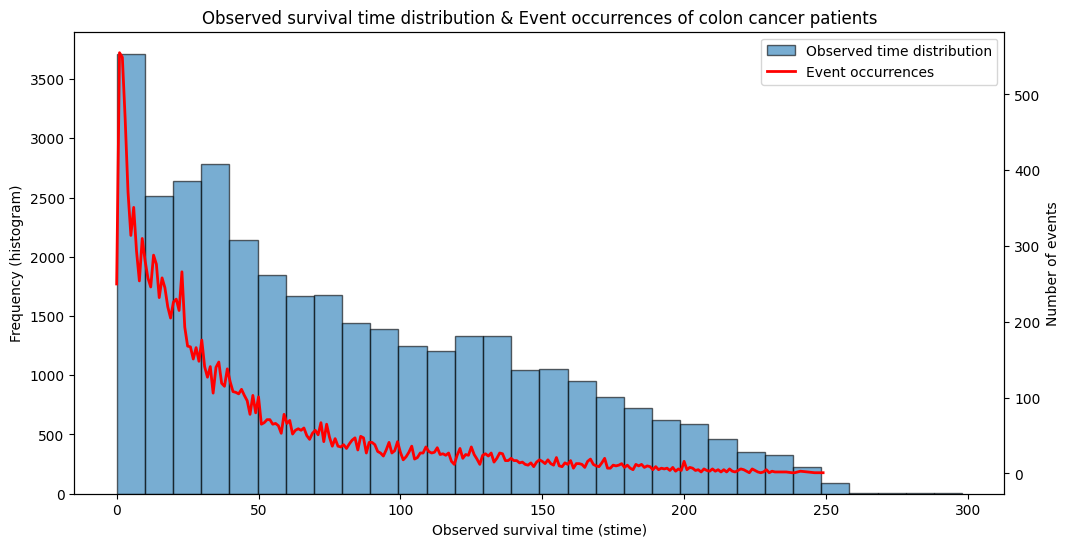

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 데이터 로드
data = pd.read_csv("origin_colon_cancer.csv")
data = data[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000','tx_00000'
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
         'Regional', 'Distant', 'sex',]]


# 1) stime 히스토그램
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.hist(data['stime'], bins=30, edgecolor='black', alpha=0.6, label="Observed time distribution")

# 2) event 발생 분포 (꺾은선그래프)
event_counts = data[data['event_inc']==1].groupby('stime').size()

ax2 = ax1.twinx()  # 새로운 y축
ax2.plot(event_counts.index, event_counts.values, color='red', lw=2, label="Event occurrences")

# 제목, 라벨
ax1.set_title("Observed survival time distribution & Event occurrences of colon cancer patients")
ax1.set_xlabel("Observed survival time (stime)")
ax1.set_ylabel("Frequency (histogram)")
ax2.set_ylabel("Number of events")

# 범례 따로 처리 (히스토그램 + 라인 둘 다 표시하려면)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.show()

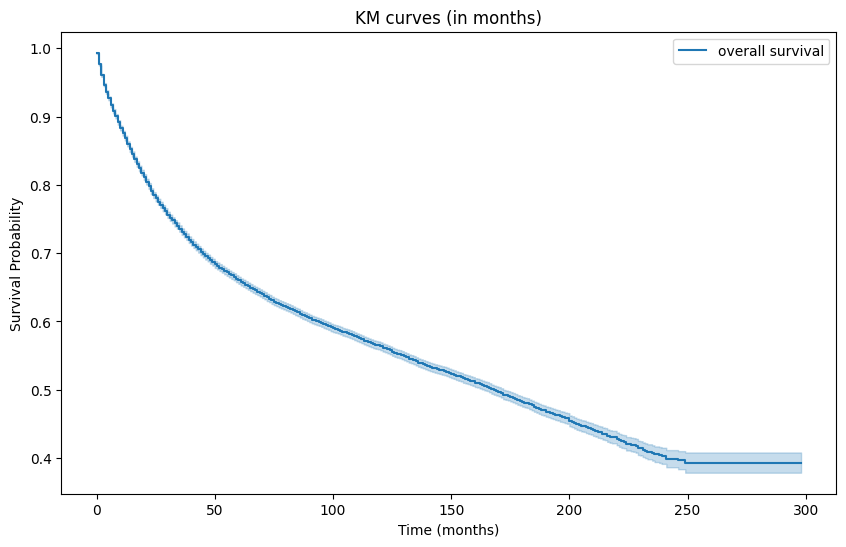

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(durations=data['stime'], event_observed=data['event_inc'], label = "overall survival")
kmf.plot_survival_function(ci_show=True, figsize=(10, 6))
# 데이터 읽기 및 필요한 변수 선택
plt.title("KM curves (in months)")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.show()

In [1]:
import xgbse
print(xgbse.__version__)  # XGBSE 버전 확인

0.3.3


# XAI 도출

In [4]:
import numpy as np
np.random.seed(42)

In [ ]:
# -----------------------------------
# 0. 경고 무시 및 Optuna 로그 설정
# -----------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)  # 경고 무시

import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

# -----------------------------------
# 1. 기본 라이브러리 불러오기
# -----------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import RepeatedKFold, train_test_split
from sksurv.metrics import (
    concordance_index_ipcw,
    integrated_brier_score,
    brier_score,
)
from xgbse import XGBSEKaplanTree
from xgbse.converters import convert_to_structured

# -----------------------------------
# 2. 데이터 로드 및 전처리
# -----------------------------------
data = pd.read_csv("origin_colon_cancer.csv")
data = data[['stime', 'event_inc', 'age_scaled', 'tx_00100', 'tx_01000','tx_00000'
         'tx_10000', 'tx_10100', 'tx_01100', 'tx_11000', 'tx_11100',
         'Regional', 'Distant', 'sex',]]
X = data.drop(['stime', 'event_inc'], axis=1)
T = data['stime']
E = data['event_inc']
# 수동으로 structured array 생성
y = np.array(list(zip(E.astype(bool), T.astype(float))),
             dtype=[('event', bool), ('time', float)])
print("y의 필드 이름:", y.dtype.names)

# -----------------------------------
# 3. 교차검증 객체 설정
# -----------------------------------
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)


best_xgb_params = {"learning_rate": 0.08421634140443258
    ,"max_depth": 8
    ,"subsample": 0.9437995216957199
    ,"n_estimators": 234,
    "seed":42,
    "tree_mehod":"hist",
    "objective": "survival:cox",
    "eval_metric":"cox-nloglik",
    "booster":"dart"}

cindex_scores = []
ibs_scores    = []
fold_times    = []
fold_brier    = []

for fold, (train_idx, test_idx) in enumerate(rkf.split(X), 1):
    X_full, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_full, y_test = y[train_idx], y[test_idx]

    test_times = y_test['time']
    time_bins = np.linspace(0, test_times.max(), 50)

    # 학습 & 예측
    model = XGBSEKaplanTree(best_xgb_params)
    model.fit(X_full, y_full, time_bins=time_bins)
    surv_df = model.predict(X_test)

    times = surv_df.columns.astype(float)
    valid_times = times[times < test_times.max()]
    surv_trim = surv_df.loc[:, valid_times]
    risk_scores = -surv_trim.iloc[:, -1].values

    # C-index & IBS 계산
    cidx = concordance_index_ipcw(y_full, y_test, risk_scores, tau=None)[0]
    ibs  = integrated_brier_score(y_full, y_test, surv_trim, valid_times)
    t_grid, b = brier_score(y_full, y_test, surv_trim, valid_times)

    cindex_scores.append(cidx)
    ibs_scores.append(ibs)
    fold_times.append(t_grid)
    fold_brier.append(b)

    print(f"폴드 {fold} — C-index: {cidx:.3f}, IBS: {ibs:.3f}")

print(f"\n평균 C-index: {np.mean(cindex_scores):.3f} ± {np.std(cindex_scores):.3f}")
print(f"평균 IBS:     {np.mean(ibs_scores):.3f} ± {np.std(ibs_scores):.3f}")

# -----------------------------------
# 7. 최적 폴드 저장 및 시각화
# -----------------------------------
os.makedirs("BS_results", exist_ok=True)
best_idx   = int(np.argmin(ibs_scores))
best_time  = fold_times[best_idx]
best_brier = fold_brier[best_idx]

np.save("BS_results/survxgboost_best_time.npy", best_time)
np.save("BS_results/survxgboost_best_brier.npy", best_brier)

plt.figure(figsize=(10, 6))
for i, (t, b) in enumerate(zip(fold_times, fold_brier), 1):
    plt.plot(t, b, label=f'폴드 {i}', alpha=0.7)
plt.xlabel('시간')
plt.ylabel('브리어 점수')
plt.title('시간 의존 브리어 점수 (최적화된 XGBSEKaplanTree)')
plt.legend()
plt.savefig("BS_results/brier_score_plot.png")
plt.close()

y의 필드 이름: ('event', 'time')
폴드 1 — C-index: 0.743, IBS: 0.142
폴드 2 — C-index: 0.734, IBS: 0.149
폴드 3 — C-index: 0.842, IBS: 0.156
폴드 4 — C-index: 0.733, IBS: 0.141
폴드 5 — C-index: 0.730, IBS: 0.141
폴드 6 — C-index: 0.732, IBS: 0.151
폴드 7 — C-index: 0.728, IBS: 0.147
폴드 8 — C-index: 0.737, IBS: 0.137
폴드 9 — C-index: 0.734, IBS: 0.146
폴드 10 — C-index: 0.757, IBS: 0.149
폴드 11 — C-index: 0.788, IBS: 0.158
폴드 12 — C-index: 0.734, IBS: 0.142
폴드 13 — C-index: 0.739, IBS: 0.147
폴드 14 — C-index: 0.743, IBS: 0.144
폴드 15 — C-index: 0.738, IBS: 0.142
폴드 16 — C-index: 0.736, IBS: 0.138
폴드 17 — C-index: 0.724, IBS: 0.158
폴드 18 — C-index: 0.744, IBS: 0.143
폴드 19 — C-index: 0.740, IBS: 0.142
폴드 20 — C-index: 0.737, IBS: 0.147
폴드 21 — C-index: 0.742, IBS: 0.146
폴드 22 — C-index: 0.745, IBS: 0.138
폴드 23 — C-index: 0.726, IBS: 0.148
폴드 24 — C-index: 0.733, IBS: 0.150
폴드 25 — C-index: 0.738, IBS: 0.145

평균 C-index: 0.743 ± 0.024
평균 IBS:     0.146 ± 0.006


## Shap

In [6]:
import shap
# Kernel SHAP용 예측 함수
def predict_risk(X_input):
    # DataFrame으로 변환하고, float로 캐스팅
    X_df = pd.DataFrame(X_input, columns=X_test.columns).astype(float)
    surv_df = model.predict(X_df)  # 생존 곡선 예측
    risk_scores = -surv_df.iloc[:, -1].values  # 마지막 시점 생존확률에 음수 부호 → 위험 점수
    return risk_scores

# 배경/샘플 데이터도 float으로 캐스팅
X_background = X_full.iloc[:100].astype(float).values
X_sample = X_test.iloc[:50].astype(float).values

  0%|          | 0/50 [00:00<?, ?it/s]

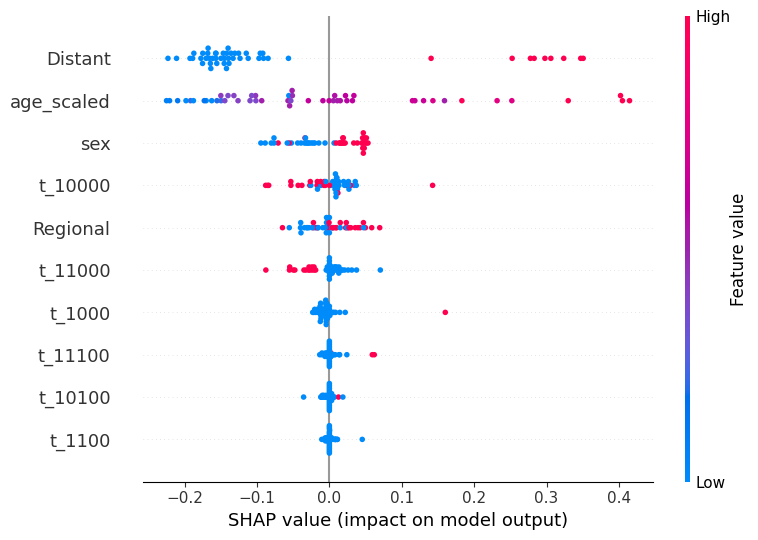

In [7]:
explainer = shap.KernelExplainer(predict_risk, X_background)
shap_values = explainer.shap_values(X_sample, nsamples=100)

shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=X_test.columns.tolist(),
    plot_type="dot",
    max_display=10
)

## Permutation importance

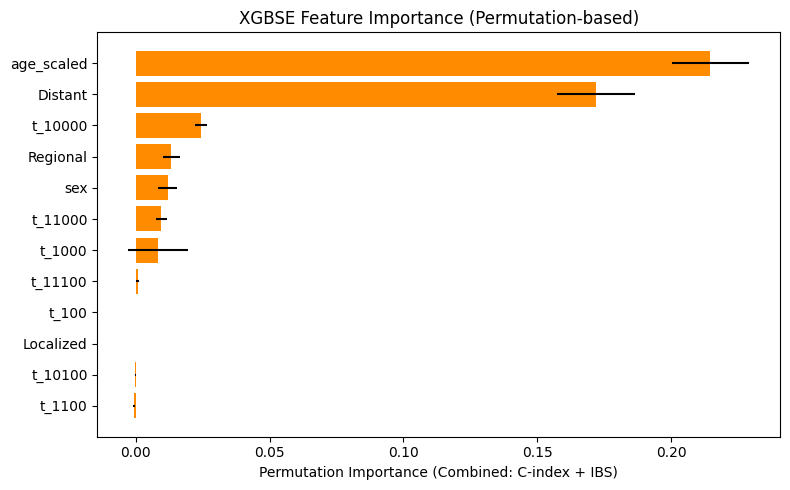

In [8]:
from sklearn.utils.validation import check_is_fitted
from sksurv.metrics import concordance_index_ipcw, integrated_brier_score

def xgbse_combined_score(estimator, X, y):
    check_is_fitted(estimator)

    # 생존 곡선 예측
    surv_df = estimator.predict(X)
    all_times = surv_df.columns.astype(float)

    # 테스트 데이터 시간 내의 time grid만 사용
    valid_times = all_times[all_times < y["time"].max()]
    surv_preds = surv_df.loc[:, valid_times].to_numpy()

    risk_scores = -surv_preds[:, -1]

    cindex = concordance_index_ipcw(y_train_best, y, risk_scores)[0]
    ibs = integrated_brier_score(y_train_best, y, surv_preds, valid_times)

    return -(ibs - cindex)

train_df_best = data.iloc[list(rkf.split(X))[best_idx][0]].copy()
test_df_best  = data.iloc[list(rkf.split(X))[best_idx][1]].copy()

X_train_best = train_df_best.drop(['stime', 'event_inc'], axis=1).astype(float)
X_test_best = test_df_best.drop(['stime', 'event_inc'], axis=1).astype(float)

y_train_best = np.array([(bool(e), t) for e, t in zip(train_df_best['event_inc'], train_df_best['stime'])],
                        dtype=[('event', 'bool'), ('time', 'f8')])
y_test_best = np.array([(bool(e), t) for e, t in zip(test_df_best['event_inc'], test_df_best['stime'])],
                       dtype=[('event', 'bool'), ('time', 'f8')])

from xgbse import XGBSEKaplanTree

xgbse_best = XGBSEKaplanTree(best_xgb_params)
time_bins_best = np.linspace(0, y_train_best['time'].max(), 50)
xgbse_best.fit(X_train_best, y_train_best, time_bins=time_bins_best)

from sklearn.inspection import permutation_importance

result = permutation_importance(
    estimator=xgbse_best,
    X=X_test_best,
    y=y_test_best,
    scoring=xgbse_combined_score,
    n_repeats=10,
    random_state=42
)

# 결과 정리
perm_df = pd.DataFrame({
    'feature': X_test_best.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(perm_df['feature'], perm_df['importance_mean'], xerr=perm_df['importance_std'], color='darkorange')
plt.xlabel("Permutation Importance (Combined: C-index + IBS)")
plt.title("XGBSE Feature Importance (Permutation-based)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# XGBSE - 리프임베딩 스터디

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 1) 예제 데이터 생성
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

print(X.shape)
print(y.shape)

# 2) XGBoost 모델 학습
dtrain = xgb.DMatrix(X, label=y)
xgb_params = {
    "objective": "binary:logistic",
    "max_depth": 4,
    "eta": 0.1,
    "verbosity": 0
}

bst = xgb.train(xgb_params, dtrain, num_boost_round=20)


# 3) XGBoost leaf 임베딩
#    pred_leaf=True 로 하면 (n_samples, n_trees) 형태의 정수 배열 반환
leaf_indices_xgb = bst.predict(dtrain, pred_leaf=True)
print("XGBoost leaf embedding shape:", leaf_indices_xgb.shape)
print(leaf_indices_xgb[:5])

# 예)
# [[12 34  7 ...  3 10 15]
#  [ 8 24  9 ...  1  5 11]
#  …]

# 4) Scikit-learn RandomForest 모델 학습
rf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=42)
rf.fit(X, y)

# 5) RandomForest leaf 임베딩
#    .apply(X) → (n_samples, n_trees) 형태로 각 샘플이 속한 leaf index 반환
leaf_indices_rf = rf.apply(X)
print("RF leaf embedding shape:", leaf_indices_rf.shape)
print(leaf_indices_rf[:5])

# 예)
# [[ 2  5  3 ... 10  6  4]
#  [ 1  3  8 ... 12  2  7]
#  …]

# 6) (옵션) One-Hot 인코딩해서 실제 임베딩 벡터로 변환
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
# # leaf_indices 을 문자열로 바꿔주면 트리별 구분 유지
# leaves_str = leaf_indices_xgb.astype(str)
# leaf_ohe = enc.fit_transform(leaves_str)
# print("One-hot embedded shape:", leaf_ohe.shape)

(1000, 10)
(1000,)
XGBoost leaf embedding shape: (1000, 20)
[[13. 15. 13. 15. 14. 15. 17. 16. 17. 16. 16. 15. 14. 14. 14. 15. 15. 15.
  13. 15.]
 [ 9. 12.  9. 12. 17. 12. 21. 12. 21. 23. 12. 23.  6.  6.  6.  6.  6.  6.
   6.  6.]
 [ 9. 19.  9. 19. 17. 19. 21. 21. 21. 23. 21. 23. 21. 22. 20. 20. 20. 20.
  20. 20.]
 [14. 16. 14. 15. 13. 15. 16. 16. 16. 16. 16. 17. 15. 15. 13. 14. 13. 14.
  13. 13.]
 [17. 12. 20. 12. 22. 12. 26. 12. 25. 28. 12. 28.  6.  6.  6.  6.  6.  6.
   6.  6.]]
RF leaf embedding shape: (1000, 10)
[[ 5  8 25 22 15 17 27  7 16 14]
 [15 15  3  6  4  6  5 16  6 20]
 [14 24  5 11  4 17 13 15  4 26]
 [ 8  8 25 22 15 17 27  7 16 14]
 [15 16  5 11  4 17  5 15 11 20]]


In [3]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# data
X,y = make_classification(n_samples = 80_000, random_state=10)

# split
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = train_test_split(
    X_full_train, y_full_train, test_size=0.5, random_state=10
)


random_trees_embedding = RandomTreesEmbedding(
    n_estimators=10,
    max_depth=4,
    random_state=10)


rt_model = make_pipeline(random_trees_embedding, LogisticRegression(max_iter=1000))
rt_model.fit(X_train_linear, y_train_linear)


Pipeline(steps=[('randomtreesembedding',
                 RandomTreesEmbedding(max_depth=4, n_estimators=10,
                                      random_state=10)),
                ('logisticregression', LogisticRegression(max_iter=1000))])